In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image

import imageio
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join

In [ ]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
!rm  images/*.mat

In [ ]:
import tensorflow as tf


def double_conv(inputs_conv,filters):
    
    #first conv
    conv1 = tf.keras.layers.Conv2D(filters,kernel_size=3, padding='same', kernel_initializer='HeNormal')(inputs_conv)
    batch1 = tf.keras.layers.BatchNormalization()(conv1)
    relu = tf.keras.layers.Activation('relu')(batch1)
    
    #second conv
    conv2 = tf.keras.layers.Conv2D(filters,kernel_size=3, padding='same', kernel_initializer='HeNormal')(relu)
    batch2 = tf.keras.layers.BatchNormalization()(conv2)
    relu2 = tf.keras.layers.Activation('relu')(batch2)
    
    return relu2
    

def unet_encoder(inputs_encoder, filters):

    #double conv output
    conv = double_conv(inputs_encoder,filters)

    #pooling
    pool = tf.keras.layers.MaxPool2D(pool_size=(2,2))(conv)

    return conv, pool

def unet_decoder(inputs_decoder,filters,previous_conv):
    
    deconv = tf.keras.layers.Conv2DTranspose(filters,kernel_size=(3,3),strides=(2,2),padding="same")(inputs_decoder)
    concat = tf.keras.layers.Concatenate()([previous_conv,deconv])
    decoder = double_conv(concat, filters)
    
    return decoder


def unet_model(inputs, filters):

    input_intermediate = tf.keras.Input(inputs)
    
    #Encoder
    conv1, pool1 = unet_encoder(input_intermediate, filters)
    conv2, pool2 = unet_encoder(pool1, filters*2)
    conv3, pool3 = unet_encoder(pool2, filters*4)
    conv4, pool4 = unet_encoder(pool3, filters*8)
    

    #Bottleneck 
    bn, _ = unet_encoder(pool4, filters*16)

    #Decoder
    deconv1 = unet_decoder(bn, filters*8, conv4)
    deconv2 = unet_decoder(deconv1, filters*4, conv3)
    deconv3 = unet_decoder(deconv2, filters*2, conv2)
    deconv4 = unet_decoder(deconv3, filters, conv1)


    out = tf.keras.layers.Conv2D(3,kernel_size=3,padding='same', activation = 'softmax')(deconv4)
    model = tf.keras.Model(inputs=input_intermediate, outputs=out)

    return model 


In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image

import imageio
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join


class DataGen(tf.keras.utils.Sequence):
    
    def __init__(self, img_size, mask_size, imgs, masks, batch_size=16): 
        
        self.img_size = img_size
        self.mask_size = mask_size
        self.imgs = imgs         
        self.masks = masks
        self.batch_size = batch_size
        
                
    def __len__(self):
        return len(self.imgs)//self.batch_size
    
    def __getitem__(self, index):

        img_batch = self.imgs[ index*self.batch_size:(index + 1)*self.batch_size]
        mask_batch = self.masks[ index*self.batch_size:(index + 1)*self.batch_size]
        
        #x, y =[], []
        #for image, mask in zip(img_batch, mask_batch):

        x = np.zeros((self.batch_size,) + self.img_size, dtype="float32")
        for j, path in enumerate(img_batch):
          img = tf.keras.preprocessing.image.load_img(img_path + '/'+path, target_size=self.img_size)
          x[j] = img

        y = np.zeros((self.batch_size,) + self.mask_size, dtype="uint8")
        for j, path in enumerate(mask_batch):
          img = tf.keras.preprocessing.image.load_img(mask_path + '/'+path, target_size=self.img_size, color_mode="grayscale")
          y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
          y[j] -= 1
        
        return x, y
            


In [ ]:
img_size = (128,128,3)
mask_size = (128,128,1)
filters = 64
img_path = '/content/images'
mask_path = '/content/annotations/trimaps'

imgs = [f for f in listdir(img_path) 
                  if (isfile(join(img_path,f)) and f.endswith(".jpg"))]

masks = [f for f in listdir(mask_path) 
                  if (isfile(join(mask_path,f)) and f.endswith(".png") and not f.startswith("."))]

masks_ordored = [masks[masks.index(imgs[i].split('.')[0]+'.png')] for i in range(len(imgs))] 

In [ ]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(imgs)
random.Random(1337).shuffle(masks_ordored)
train_imgs = imgs[:-val_samples]
train_target_imgs = masks_ordored[:-val_samples]
val_img = imgs[-val_samples:]
val_target_img = masks_ordored[-val_samples:]


train_data = DataGen(img_size, mask_size, train_imgs, train_target_imgs)
valid_data = DataGen(img_size, mask_size, val_img, val_target_img)

unet = unet_model(img_size,filters)

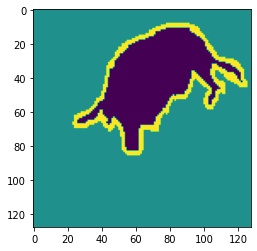

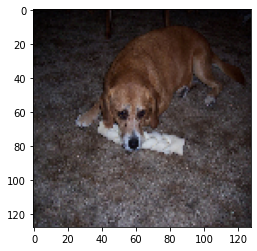

In [ ]:
import matplotlib.pyplot as plt


plt.imshow(tf.squeeze(train_data.__getitem__(1)[1][1]))
plt.figure()
plt.imshow((train_data.__getitem__(1)[0][1]).astype(np.uint8))

In [ ]:
unet.compile(optimizer='Adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

unet.fit(train_data, epochs=10, validation_data=valid_data)

Epoch 1/10
399/399 [==============================] - 214s 530ms/step - loss: 0.5928 - accuracy: 0.3098 - val_loss: 0.7069 - val_accuracy: 0.4559
Epoch 2/10
399/399 [==============================] - 211s 528ms/step - loss: 0.4285 - accuracy: 0.3149 - val_loss: 0.3879 - val_accuracy: 0.3254
Epoch 3/10
399/399 [==============================] - 211s 528ms/step - loss: 0.3653 - accuracy: 0.3135 - val_loss: 0.3497 - val_accuracy: 0.2739
Epoch 4/10
399/399 [==============================] - 211s 528ms/step - loss: 0.3324 - accuracy: 0.3121 - val_loss: 0.3266 - val_accuracy: 0.3287
Epoch 5/10
399/399 [==============================] - 210s 527ms/step - loss: 0.3034 - accuracy: 0.3129 - val_loss: 0.3203 - val_accuracy: 0.3036
Epoch 6/10
399/399 [==============================] - 211s 527ms/step - loss: 0.2838 - accuracy: 0.3116 - val_loss: 0.2954 - val_accuracy: 0.3092
Epoch 7/10
399/399 [==============================] - 211s 527ms/step - loss: 0.2644 - accuracy: 0.3116 - val_loss: 0.3046 -

In [ ]:
val_gen = DataGen(img_size, mask_size, val_img, val_target_img)
val_preds = unet.predict(val_gen)




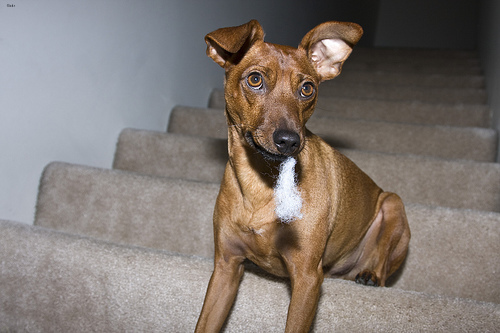

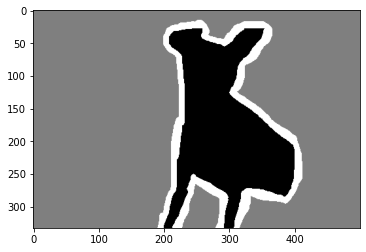

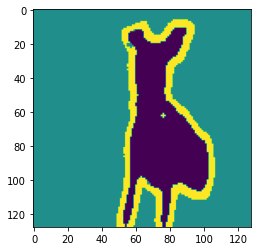

In [ ]:
from IPython.display import display, Image
import PIL
from PIL import ImageOps

def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(tf.keras.preprocessing.image.array_to_img(mask))
    plt.imshow(img)


# Display results for validation image 
i = 900

# Display input image
display(Image(filename='/content/images/'+val_img[i]))

# Display ground-truth target mask
img = ImageOps.autocontrast(tf.keras.preprocessing.image.load_img('/content/annotations/trimaps/'+val_target_img[i]))
plt.imshow(img)

plt.figure()
# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inp